In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from amb import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ALLCools.plot import *
age_palette = get_age_palette()
import glob
import pathlib

In [3]:
_dir = 'ABC.By.ATAC.RPM'
ct = 'CA3_Glut'
_scale = 1000000

In [5]:
gene_meta = pd.read_csv('/home/qzeng_salk_edu/project/240321_abc_score/use.mouse_genes.csv', index_col = 0)
gene_name_to_id= {v:k for k,v in gene_meta['gene_name'].to_dict().items()}

In [24]:
def get_use_df(ct, age):
    df = pd.read_csv(f'{_dir}/{ct}/{ct}.{age}.abc_score.csv', index_col = 0)
    df['norm_contact'] = df['contact'].div(df['contact'].sum()) * _scale
    cutoff = np.percentile(df['contact'], 90)
    df = df[df['contact'] >= cutoff]
    df['gene_id'] = df.index.map(lambda x: x.split('-')[-1])
    return df

In [25]:
domain_gene_dir = '/home/qzeng_salk_edu/project/240424_domain_gene/Domain.Genes.Expression'
use_genes = pd.read_csv(f'{domain_gene_dir}/{ct}/DiffExpress.DomainGene.csv', index_col = 0)
use_genes_ids = [gene_name_to_id[gene_name] for gene_name in use_genes.index]

In [26]:
young_df = get_use_df(ct, '8wk')
old_df = get_use_df(ct, '18mo')

In [27]:
young_df =young_df[young_df['gene_id'].isin(use_genes_ids)]
old_df =old_df[old_df['gene_id'].isin(use_genes_ids)]

In [28]:
young_df.head()

,activity,contact,abc_score,norm_contact,gene_id
chr1:51758793-51759294-ENSMUSG00000018417,6.148075,5,2.795414,1.700407,ENSMUSG00000018417
chr1:51758270-51758771-ENSMUSG00000018417,1.871575,5,0.850970,1.700407,ENSMUSG00000018417
chr1:51800665-51801166-ENSMUSG00000018417,1.163673,7,0.740741,2.380569,ENSMUSG00000018417
chr1:51808812-51809313-ENSMUSG00000018417,0.746690,7,0.475309,2.380569,ENSMUSG00000018417
chr1:51808311-51808812-ENSMUSG00000018417,1.454592,7,0.925926,2.380569,ENSMUSG00000018417


In [29]:
all_to_plot = []
for gene_id , tmpdf in young_df.groupby('gene_id'):
    tmpdf['rank'] = tmpdf['abc_score'].rank()
    tmpdf['importance_score'] = tmpdf['rank']/tmpdf.shape[0]
    all_to_plot.append(tmpdf)
young_df = pd.concat(all_to_plot)

In [30]:
all_to_plot = []
for gene_id , tmpdf in old_df.groupby('gene_id'):
    tmpdf['rank'] = tmpdf['abc_score'].rank()
    tmpdf['importance_score'] = tmpdf['rank']/tmpdf.shape[0]
    all_to_plot.append(tmpdf)
old_df = pd.concat(all_to_plot)

In [48]:
to_plot = pd.concat([young_df, old_df], axis = 1)
to_plot = to_plot.fillna(0)
to_plot.columns = ['8wk.activity', '8wk.contacts','8wk.abc','8wk.norm_contact',
                     'gene_id','8wk.rank','8wk.importance_score', 
                     '18mo.activity', '18mo.contacts','18mo.abc','18mo.norm_contact',
                  'gene_id','18mo.rank','18mo.importance_score']
to_plot = to_plot[['8wk.activity', '8wk.contacts','8wk.abc','8wk.norm_contact',
                   '8wk.rank','8wk.importance_score', 
                   '18mo.activity', '18mo.contacts','18mo.abc','18mo.norm_contact',
                   '18mo.rank','18mo.importance_score']]

In [53]:
to_plot['contact_change'] = to_plot['18mo.norm_contact'] - to_plot['8wk.norm_contact']
to_plot['activity_change'] = to_plot['18mo.activity'] - to_plot['8wk.activity']
to_plot['Importance_Score_Change'] = to_plot['18mo.importance_score'] - to_plot['8wk.importance_score'] 

In [54]:
to_plot['gene_id'] = to_plot.index.map(lambda x: x.split('-')[-1])
to_plot['enhancer_start'] = to_plot.index.map(lambda x: int(x.split(':')[-1].split('-')[0]))
to_plot['gene_start'] = to_plot['gene_id'].map(gene_meta['start'].to_dict())
to_plot['gene_end'] = to_plot['gene_id'].map(gene_meta['end'].to_dict())

to_plot['eg_dist'] = np.minimum((to_plot['gene_id'].map(gene_meta['start']) - to_plot['enhancer_start']).abs(),
                                 (to_plot['gene_id'].map(gene_meta['end']) - to_plot['enhancer_start']).abs())

In [62]:
def set_cat(x, value):
    if x > value:
        cat = 'Old Active'
    elif x < -value:
        cat = 'Young Active'
    else:
        cat = 'Non Age Dynamic'
    return cat
to_plot['Enhancer_Category'] = to_plot['Importance_Score_Change'].apply(lambda x: set_cat(x, 0.3))

Text(0.5, 1.0, 'Activity Change (Young-Old)')

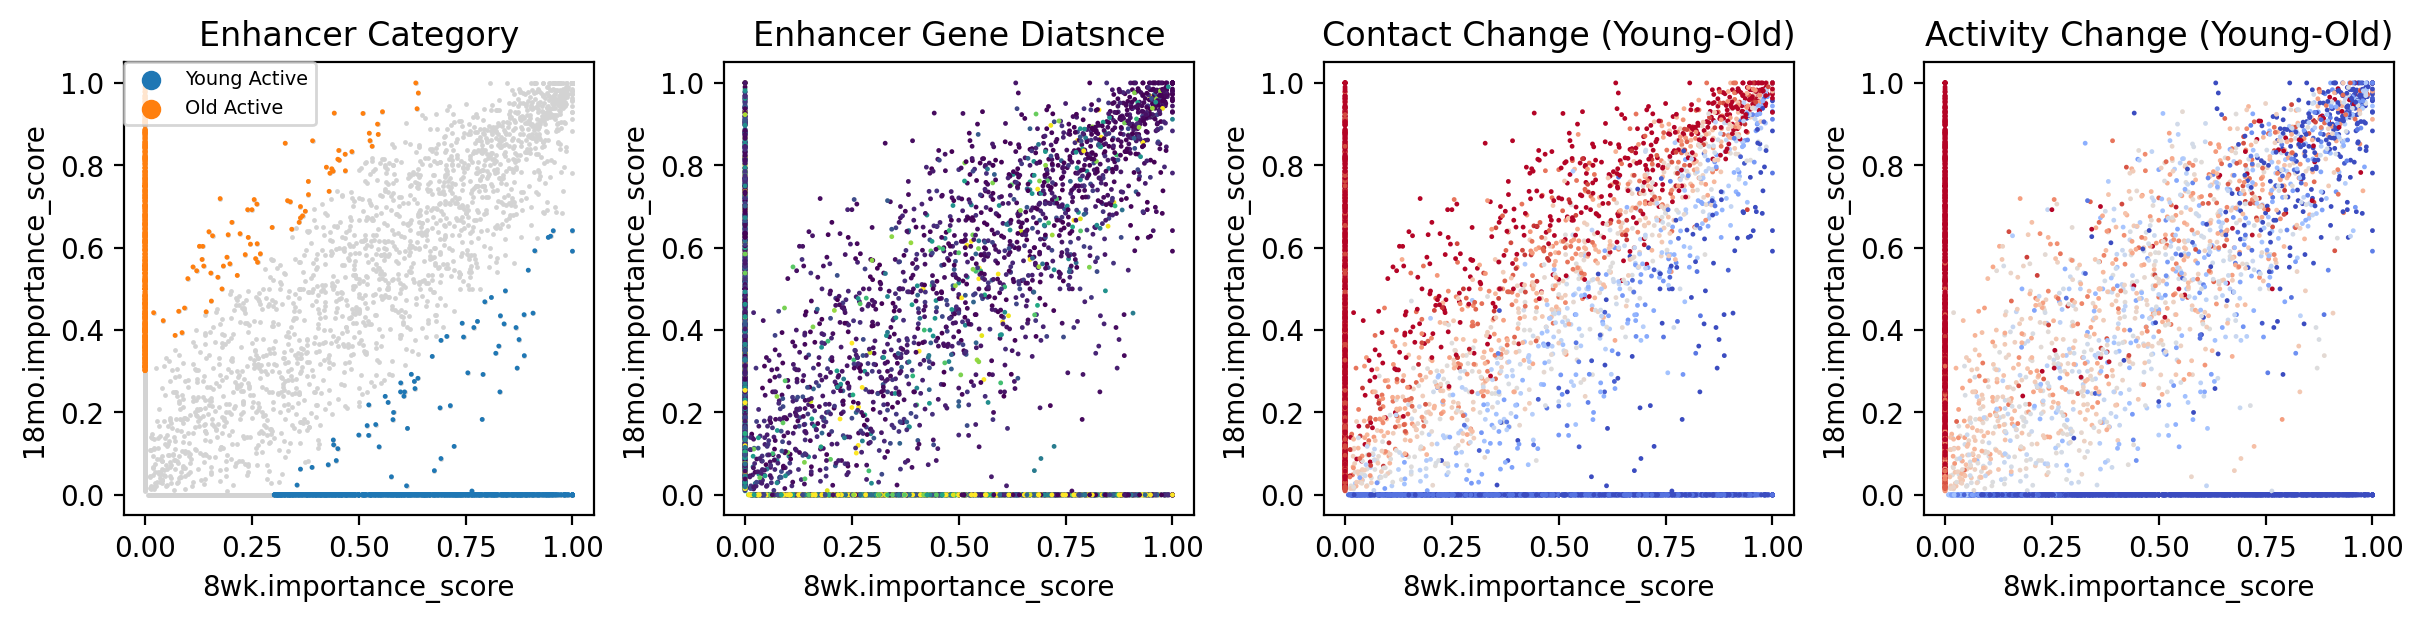

In [65]:
x = '8wk.importance_score'
y = '18mo.importance_score'

fig, axes = plt.subplots(figsize = (12,3), ncols = 4, dpi = 200, constrained_layout = True)

ax= axes[0]
sns.scatterplot(data = to_plot,
                color = 'lightgrey',
                linewidth = 0,
                ax = ax,s =3,
                x = x,
                y = y)
sns.scatterplot(data = to_plot[to_plot['Enhancer_Category'] != 'Non Age Dynamic'],
                hue = 'Enhancer_Category',
                linewidth = 0,
                ax = ax,s =3,
                x = x,
                y = y)
ax.legend(loc='upper left', borderaxespad=0,fontsize='x-small') #bbox_to_anchor=(1.05, 1), 
ax.set_title("Enhancer Category")


ax= axes[1]
value = np.percentile(to_plot['eg_dist'], 90)
sns.scatterplot(data = to_plot,
                hue = 'eg_dist',
                palette ='viridis',
                hue_norm = (0,value),
                legend = False,
                linewidth = 0,
                ax = ax,s =3,
                x = x,
                y = y)
ax.set_title("Enhancer Gene Diatsnce")

ax= axes[2]
value = np.percentile(to_plot['contact_change'], 80)
sns.scatterplot(data = to_plot,
                hue = 'contact_change',
                palette ='coolwarm',
                hue_norm = (-value,value),
                legend = False,
                linewidth = 0,
                ax = ax,s =3,
                x = x,
                y = y)
ax.set_title("Contact Change (Young-Old)")

ax= axes[3]
value = np.percentile(to_plot['activity_change'], 80)
sns.scatterplot(data = to_plot,
                hue = 'activity_change',
                palette ='coolwarm',
                hue_norm = (-value,value),
                legend = False,
                linewidth = 0,
                ax = ax,s =3,
                x = x,
                y = y)
ax.set_title("Activity Change (Young-Old)")